In [1]:
from torchvision.datasets import MNIST
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [2]:
from test_utils import compute_log_likelihood_importance_sampling, compute_log_likelihood_monte_carlo, model_test_loss
from train_utils import train_model
from losses import binary_crossentropy_loss
from mask_generators import generate_horizontal_line
from nn_utils import MemData, Reshape, MergeSkipConnection, AddSkipConnection, ResNetBlock
from UCM import UCM

In [3]:
def generate_horizontal_line_MNIST(batch_size):
    return generate_horizontal_line(batch_size, 28, 28, 3)

In [4]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

In [5]:
train_data.tensors = (train_data.tensors[0].round(),)
test_data.tensors = (test_data.tensors[0].round(),)

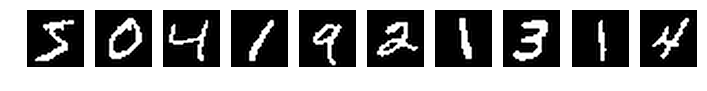

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(Variable(train_data[:10][0]))

In [7]:
d = 16

In [8]:
skip_connection_0 = MemData()
skip_connection_1 = MemData()
skip_connection_2 = MemData()
skip_connection_3 = MemData()
proposal_network = nn.Sequential(
    Reshape(2, 28, 28),
    ResNetBlock(2, 6, 2),
    ResNetBlock(6, 16, 2),
    Reshape(-1),
    nn.Linear(784, 256),
    nn.LeakyReLU(inplace=True),
)
proposal_mu_head = nn.Linear(256, d)
proposal_sigma_head = nn.Linear(256, d)
prior_network = nn.Sequential(
    Reshape(2, 28, 28),
    skip_connection_0,
    ResNetBlock(2, 6, 2),
    skip_connection_1,
    ResNetBlock(6, 16, 2),
    skip_connection_2,
    Reshape(-1),
    nn.Linear(784, 256),
    nn.LeakyReLU(inplace=True),
    skip_connection_3,
)
prior_mu_head = nn.Linear(256, d)
prior_sigma_head = nn.Linear(256, d)
generative_network = nn.Sequential(
    nn.Linear(d, 256),
    nn.LeakyReLU(),
    MergeSkipConnection(skip_connection_3),
    nn.Linear(256 + 256, 784),
    nn.LeakyReLU(),
    Reshape(16, 7, 7),
    MergeSkipConnection(skip_connection_2),
    nn.Upsample(scale_factor=2),
    ResNetBlock(16 + 16, 6),
    MergeSkipConnection(skip_connection_1),
    nn.Upsample(scale_factor=2),
    MergeSkipConnection(skip_connection_0),
    ResNetBlock(6 + 6 + 2, 6),
    nn.Conv2d(6, 1, 1),
    nn.Sigmoid()
)

In [9]:
ucm_tests = [
    {
        'name': 'MC',
        'func': lambda model:
                model_test_loss(test_data, generate_horizontal_line_MNIST,
                                lambda batch, mask:
                                    compute_log_likelihood_monte_carlo(batch, mask, model,
                                                                       binary_crossentropy_loss, K=10),
                                is_cuda = True,
                                max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model:
                model_test_loss(test_data, generate_horizontal_line_MNIST,
                                lambda batch, mask:
                                    compute_log_likelihood_importance_sampling(batch, mask, model,
                                                                               binary_crossentropy_loss, K=10),
                                is_cuda = True,
                                max_batches=20)
    }
]

In [10]:
model = UCM(1, binary_crossentropy_loss,
        proposal_network, proposal_mu_head, proposal_sigma_head,
        prior_network, prior_mu_head, prior_sigma_head,
        generative_network)

In [11]:
%time model_a1 = train_model(train_data, model, generate_horizontal_line_MNIST, \
                             tests=ucm_tests, batch_size=200, test_freq=100, num_epochs=30, learning_rate=1e-3)

Epoch 0 Train loss -163.77603149414062 Batch 300 of 300           
Epoch 1 Train loss -100.07379913330078 Batch 300 of 300           
Epoch 2 Train loss -81.78832244873047 Batch 300 of 300           
Epoch 3 Train loss -77.7652587890625 Batch 300 of 300            
Epoch 4 Train loss -77.19944763183594 Batch 300 of 300           
Epoch 5 Train loss -73.96827697753906 Batch 300 of 300           
Epoch 6 Train loss -72.53165435791016 Batch 300 of 300           
Epoch 7 Train loss -71.21075439453125 Batch 300 of 300           
Epoch 8 Train loss -70.7806396484375 Batch 300 of 300            
Epoch 9 Train loss -72.95845794677734 Batch 300 of 300           
Epoch 10 Train loss -70.41679382324219 Batch 300 of 300           
Epoch 11 Train loss -70.38959503173828 Batch 300 of 300           
Epoch 12 Train loss -70.47540283203125 Batch 300 of 300           
Epoch 13 Train loss -67.1568603515625 Batch 300 of 300            
Epoch 14 Train loss -67.48118591308594 Batch 300 of 300           
Epo

In [12]:
s = model_a1['model'].state_dict()
import pickle as pkl
with open('mnist.weights', 'wb') as f:
    pkl.dump(s, f)
with open('mnist.debug_info', 'wb') as f:
    pkl.dump({
        'train_losses_list': model_a1['train_losses_list'],
        'test_results': model_a1['test_results']
    }, f)

In [13]:
import pickle as pkl
with open('mnist.weights', 'rb') as f:
    s = pkl.load(f)
with open('mnist.debug_info', 'rb') as f:
    model_a1 = pkl.load(f)
model.load_state_dict(s)
model_a1['model'] = model

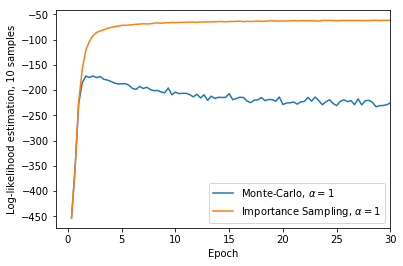

In [14]:
for label, name, model in [
    (r'Monte-Carlo, $\alpha=1$', 'MC', model_a1),
    (r'Importance Sampling, $\alpha=1$', 'IS', model_a1),
]:
    data = [x[name] for x in model_a1['test_results']]
    x_labels = (1 + np.arange(len(data))) / 3
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

In [15]:
def average(func, K=5):
    res = []
    for i in range(K):
        res.append(func())
    res = torch.Tensor(res)
    return res.mean(), res.std()

In [16]:
mc_10000 = lambda: \
    model_test_loss(test_data, generate_horizontal_line_MNIST,
                    lambda batch, b:    compute_log_likelihood_monte_carlo(batch, b,
                                                                           model_a1['model'].cuda(),
                                                                           binary_crossentropy_loss, K=10000),
                    is_cuda=True,
                    batch_size=1,
                    max_batches=30)
mc_100 = lambda: \
    model_test_loss(test_data, generate_horizontal_line_MNIST,
                    lambda batch, b:    compute_log_likelihood_monte_carlo(batch, b,
                                                                           model_a1['model'].cuda(),
                                                                           binary_crossentropy_loss, K=100),
                    is_cuda=True,
                    max_batches=30)
is_100 = lambda: \
    model_test_loss(test_data, generate_horizontal_line_MNIST,
                    lambda batch, b:    compute_log_likelihood_importance_sampling(batch, b,
                                                                                   model_a1['model'].cuda(),
                                                                                   binary_crossentropy_loss, K=100),
                    is_cuda=True,
                    max_batches=30)

In [17]:
%time print('%f \pm %f' % average(mc_10000))

-88.593002 \pm 4.099295
CPU times: user 15.6 s, sys: 5.86 s, total: 21.4 s
Wall time: 21.4 s


In [18]:
%time print('%f \pm %f' % average(mc_100))

-161.000931 \pm 0.843322
CPU times: user 19.4 s, sys: 8.15 s, total: 27.6 s
Wall time: 26.8 s


In [19]:
%time print('%f \pm %f' % average(is_100))

-60.484219 \pm 0.105895
CPU times: user 19.9 s, sys: 7.89 s, total: 27.8 s
Wall time: 27 s


In [20]:
model_a1['model'].cpu()
pass

In [21]:
def draw_sample(img):
    plt.imshow(img.reshape(28,28), cmap='Greys_r', vmin=0, vmax=1, interpolation='bilinear')
    plt.axis('off')

In [22]:
def test_sample(img0, mask0, model, K):
    img = img0.view(1, -1)
    mask = mask0.view(1, -1)
    res = {}
    res['input'] = (0.5 * mask + img0.view(1, -1) * (1 - mask)).view(28, 28).numpy()
    res['groundtruth'] = img0.view(28, 28).numpy()
    res['results'] = (model.generate_samples(img, mask, K).numpy() * mask.view(1, 1, 28 * 28) + \
                ((1 - mask) * img).view(1, 1, 28 * 28)).view(-1, 28, 28)
    return res

In [23]:
np.random.seed(123)
res = []
for i in range(10):
    while True:
        a = test_data.tensors[0][np.random.choice(test_data.tensors[0].shape[0])]
        b = generate_horizontal_line_MNIST(1)
        if np.all(a * (1 - b) == 0):
            continue
        lres = test_sample(a, b, model_a1['model'], 10)
        break
    res.append(lres)

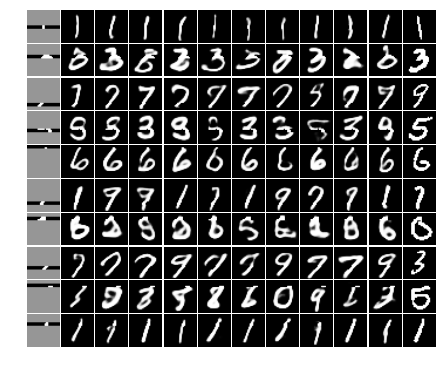

In [24]:
s = 0.5
n = 10
plt.figure(figsize=((n + 2) * s, s * len(res)))
for i in range(len(res)):
    plt.subplot(len(res), (n + 2), i * (n + 2) + 1)
    draw_sample(res[i]['input'])
    for j in range(n):
        plt.subplot(len(res), (n + 2), i * (n + 2) + j + 2)
        draw_sample(res[i]['results'][j])
    plt.subplot(len(res), (n + 2), i * (n + 2) + n + 2)
    draw_sample(res[i]['groundtruth'])
plt.tight_layout(pad=0, w_pad=-2.2, h_pad=-2.2)
plt.savefig('mnist.pdf', bbox_inches='tight')

In [25]:
model_a1['model'].cuda()
a = test_data.tensors[0][np.random.choice(test_data.tensors[0].shape[0], 10)]
b = generate_horizontal_line_MNIST(10)
%time model_a1['model'].generate_samples(a.cuda(), b.cuda(), 100)
model_a1['model'].cpu()
pass

CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 5.46 ms
